In [13]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, roc_auc_score, precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import VotingClassifier

In [ ]:
pre_post_test_df = pd.read_csv('pre_post_test_analysis.csv')
behavioural_df = pd.read_csv('behavioural_analysis.csv')
fnirs_df = pd.read_csv('fnirs_analysis.csv')
eye_tracking_df = pd.read_csv('eye_tracking_analysis.csv')  

merged_df = pre_post_test_df.merge(behavioural_df, on=['participant_number', 'subexperiment_number'])
merged_df = merged_df.merge(fnirs_df, on=['participant_number', 'subexperiment_number'])
merged_df = merged_df.merge(eye_tracking_df, on=['participant_number', 'subexperiment_number']) 

merged_df.to_csv('master.csv', index=False)
print("master.csv has been updated successfully.")

master.csv has been updated successfully.


### Calculate Median and Upper Quartile Split using 9-point Paas Score

In [ ]:
file_path = "master.csv"
df = pd.read_csv(file_path)

subject_col = 'participant_number'

median_thresholds = []
quartile_thresholds = []

def perform_splits(group):
    # Calculate the subject-specific median for the 9-point Paas score
    median_value = group['feedback_score_subexperiment'].median()
    group['median_split_feedback_score_subexperiment'] = group['feedback_score_subexperiment'].apply(
        lambda x: 1 if x >= median_value else 0
    )
    
    # Calculate the subject-specific 75th percentile (upper quartile) for the 9-point Paas score
    quartile_value = group['feedback_score_subexperiment'].quantile(0.75)
    group['quartile_split_feedback_score_subexperiment'] = group['feedback_score_subexperiment'].apply(
        lambda x: 1 if x >= quartile_value else 0
    )
    
    median_thresholds.append(median_value)
    quartile_thresholds.append(quartile_value)

    print(f"Participant {group[subject_col].iloc[0]}: median = {median_value}, upper quartile = {quartile_value}")
    return group

df = df.groupby(subject_col, group_keys=False).apply(perform_splits)

# Calculate the mean thresholds across all subjects (for reporting)
mean_median_threshold = sum(median_thresholds) / len(median_thresholds)
mean_quartile_threshold = sum(quartile_thresholds) / len(quartile_thresholds)

print("\nOverall Mean Thresholds Across All Subjects:")
print(f"Mean median-based threshold: {mean_median_threshold:.2f}")
print(f"Mean upper quartile-based threshold: {mean_quartile_threshold:.2f}")
print("\nMedian split counts:")
print(df['median_split_feedback_score_subexperiment'].value_counts())
print("\nQuartile split counts:")
print(df['quartile_split_feedback_score_subexperiment'].value_counts())

cols = df.columns.tolist()
if 'median_split_feedback_score_subexperiment' in cols:
    cols.remove('median_split_feedback_score_subexperiment')
if 'quartile_split_feedback_score_subexperiment' in cols:
    cols.remove('quartile_split_feedback_score_subexperiment')

feedback_index = cols.index('feedback_score_subexperiment')
cols.insert(feedback_index + 1, 'median_split_feedback_score_subexperiment')
cols.insert(feedback_index + 2, 'quartile_split_feedback_score_subexperiment')
df = df[cols]

df.to_csv(file_path, index=False)
print(f"{file_path} saved successfully.")

Participant 2: median = 7.0, upper quartile = 7.0
Participant 3: median = 3.5, upper quartile = 6.0
Participant 4: median = 5.5, upper quartile = 7.0
Participant 10: median = 4.0, upper quartile = 5.25
Participant 15: median = 9.0, upper quartile = 9.0
Participant 16: median = 4.5, upper quartile = 6.0
Participant 20: median = 4.0, upper quartile = 5.0
Participant 21: median = 3.0, upper quartile = 5.0
Participant 22: median = 4.5, upper quartile = 5.0
Participant 23: median = 4.0, upper quartile = 6.0
Participant 24: median = 5.0, upper quartile = 5.0
Participant 25: median = 6.5, upper quartile = 7.0
Participant 26: median = 5.0, upper quartile = 6.0
Participant 27: median = 6.0, upper quartile = 6.25
Participant 28: median = 6.5, upper quartile = 7.0
Participant 29: median = 6.0, upper quartile = 7.0
Participant 30: median = 5.5, upper quartile = 6.0
Participant 31: median = 5.0, upper quartile = 5.25
Participant 32: median = 7.0, upper quartile = 8.0
Participant 33: median = 3.5, u

### Calculate Tutorial Split using 9-point Paas Score

In [ ]:
import pandas as pd

file_path = "master.csv"
df = pd.read_csv(file_path)

# Calculate the tutorial_threshold as the average of feedback_score_tutorial_2 and feedback_score_tutorial_3
df['tutorial_threshold'] = (df['feedback_score_tutorial_2'] + df['feedback_score_tutorial_3']) / 2

# Create the tutorial_split_feedback_score_subexperiment column
df['tutorial_split_feedback_score_subexperiment'] = df.apply(
    lambda row: 1 if row['feedback_score_subexperiment'] >= row['tutorial_threshold'] else 0,
    axis=1
)

columns = df.columns.tolist()
insert_index = columns.index('feedback_score_rest_1') + 1
columns.insert(insert_index, 'tutorial_threshold')
columns.insert(insert_index + 1, 'tutorial_split_feedback_score_subexperiment')
df = df[columns]

df.to_csv(file_path, index=False)
print(f"{file_path} updated with tutorial_threshold and tutorial_split_feedback_score_subexperiment columns in the correct order.")

master.csv updated with tutorial_threshold and tutorial_split_feedback_score_subexperiment columns in the correct order.


### Calculate Counts to Observe Splitting and Imbalance

In [ ]:
tutorial_split_counts = df['tutorial_split_feedback_score_subexperiment'].value_counts()

print("Counts in tutorial_split_feedback_score_subexperiment:")
print(f"0s: {tutorial_split_counts.get(0, 0)}")
print(f"1s: {tutorial_split_counts.get(1, 0)}")

Counts in tutorial_split_feedback_score_subexperiment:
0s: 109
1s: 371


### Random Forest

Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.14      0.19        22
           1       0.78      0.91      0.84        74

    accuracy                           0.73        96
   macro avg       0.54      0.52      0.51        96
weighted avg       0.67      0.73      0.69        96


Confusion Matrix:
[[ 3 19]
 [ 7 67]]


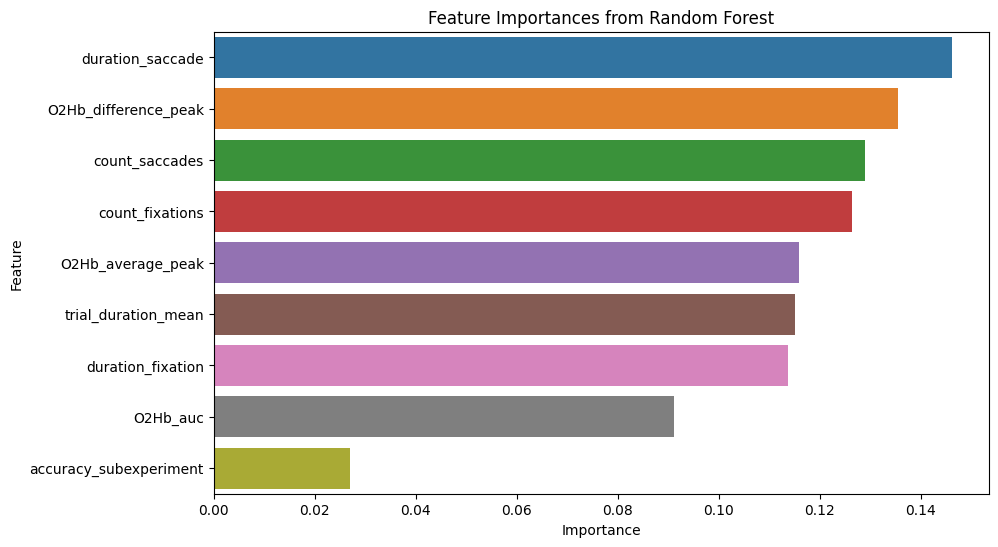

In [4]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'count_saccades', 'duration_fixation', 'duration_saccade', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment']  # Target (Low or High)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Logistic Regression

In [111]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'duration_fixation', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment']  # Target (Low or High)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.77      1.00      0.87        74

    accuracy                           0.77        96
   macro avg       0.39      0.50      0.44        96
weighted avg       0.59      0.77      0.67        96


Confusion Matrix:
[[ 0 22]
 [ 0 74]]


C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

### Linear Discriminant Analysis

In [112]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'duration_fixation', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment']  # Target (Low or High)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.77      0.97      0.86        74

    accuracy                           0.75        96
   macro avg       0.38      0.49      0.43        96
weighted avg       0.59      0.75      0.66        96


Confusion Matrix:
[[ 0 22]
 [ 2 72]]


### Support Vector Machine

In [113]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'duration_fixation', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment']  # Target (Low or High)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear'],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters found: {grid.best_params_}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'C': 100, 'class_weight': None, 'gamma': 1, 'kernel': 'linear'}
Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        22
           1       0.77      1.00      0.87        74

    accuracy                           0.77        96
   macro avg       0.89      0.50      0.44        96
weighted avg       0.82      0.77      0.67        96


Confusion Matrix:
[[ 0 22]
 [ 0 74]]


### K Means Clustering

C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


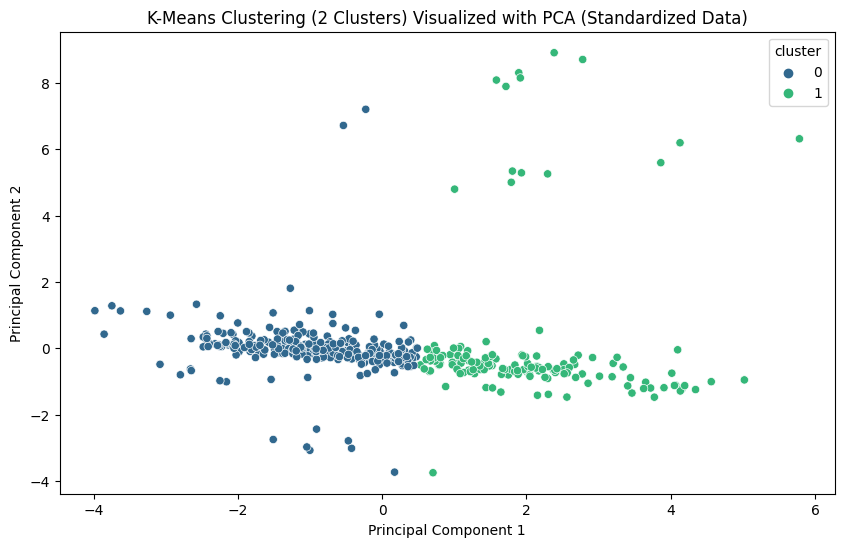

Explained variance by PC1 and PC2: [0.31029565 0.21933057]


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define features
X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 
        'count_fixations', 'count_saccades', 
        'duration_fixation', 'duration_saccade', 
        'accuracy_subexperiment', 'trial_duration_mean']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering with 2 clusters on scaled data
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Append the cluster labels to the DataFrame
df['cluster'] = clusters

# Reduce dimensions to 2 for visualization using PCA on scaled data
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='viridis')
plt.title('K-Means Clustering (2 Clusters) Visualized with PCA (Standardized Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Optional: Display explained variance ratio to know how much variance is captured
print("Explained variance by PC1 and PC2:", pca.explained_variance_ratio_)

### Labels Analysis

In [8]:
import pandas as pd

# Load the dataset
master_df = pd.read_csv('master.csv')

# Check if the column exists
if 'quartile_split_feedback_score_subexperiment' not in master_df.columns:
    print("The column 'quartile_split_feedback_score_subexperiment' does not exist in the dataset.")
else:
    # Count the occurrences of 0s and 1s
    label_counts = master_df['quartile_split_feedback_score_subexperiment'].value_counts()

    # Calculate proportions
    label_proportions = master_df['quartile_split_feedback_score_subexperiment'].value_counts(normalize=True)

    # Print the results
    print("Count of each label:")
    print(label_counts)
    print("\nProportion of each label:")
    print(label_proportions)

    # Additional analysis: Check for any missing values
    missing_values = master_df['quartile_split_feedback_score_subexperiment'].isnull().sum()
    print(f"\nNumber of missing values in 'quartile_split_feedback_score_subexperiment': {missing_values}")

    # Additional analysis: Correlation with other numerical columns
    if master_df.select_dtypes(include=['number']).shape[1] > 1:  # Ensure there are other numerical columns
        # Adjust Pandas display options to show all rows
        pd.set_option('display.max_rows', None)
        correlations = master_df.corr()['quartile_split_feedback_score_subexperiment'].drop('quartile_split_feedback_score_subexperiment')
        print("\nCorrelation of 'quartile_split_feedback_score_subexperiment' with other numerical columns:")
        print(correlations)
        # Reset Pandas display options to default
        pd.reset_option('display.max_rows')

Count of each label:
0    271
1    209
Name: quartile_split_feedback_score_subexperiment, dtype: int64

Proportion of each label:
0    0.564583
1    0.435417
Name: quartile_split_feedback_score_subexperiment, dtype: float64

Number of missing values in 'quartile_split_feedback_score_subexperiment': 0

Correlation of 'quartile_split_feedback_score_subexperiment' with other numerical columns:
participant_number                              -0.032241
subexperiment_number                             0.554738
MRTScore                                         0.010141
MRTAcc                                           0.010138
nback_hits_0                                     0.015060
nback_hit_rate_0                                 0.015060
nback_correct_rejections_0                       0.046834
nback_rt_target_0                               -0.029692
nback_rt_nontarget_0                             0.052115
nback_composite_0                                0.024407
nback_hits_1              

In [12]:
import pandas as pd

# Load the dataset
master_df = pd.read_csv('master.csv')


# Count the occurrences of 0s and 1s
label_counts = master_df['supervised_classifier_label'].value_counts()

# Calculate proportions
label_proportions = master_df['supervised_classifier_label'].value_counts(normalize=True)

# Print the results
print("Count of each label:")
print(label_counts)
print("\nProportion of each label:")
print(label_proportions)

# Additional analysis: Check for any missing values
missing_values = master_df['supervised_classifier_label'].isnull().sum()
print(f"\nNumber of missing values in 'supervised_classifier_label': {missing_values}")

# Additional analysis: Correlation with other numerical columns
if master_df.select_dtypes(include=['number']).shape[1] > 1:  # Ensure there are other numerical columns
    # Adjust Pandas display options to show all rows
    pd.set_option('display.max_rows', None)
    correlations = master_df.corr()['supervised_classifier_label'].drop('supervised_classifier_label')
    print("\nCorrelation of 'supervised_classifier_label' with other numerical columns:")
    print(correlations)
    # Reset Pandas display options to default
    pd.reset_option('display.max_rows')

# Calculate the average feedback_score_subexperiment for each label (0 and 1)
if 'feedback_score_subexperiment' in master_df.columns:
    avg_feedback_score = master_df.groupby('supervised_classifier_label')['feedback_score_subexperiment'].mean()
    print("\nAverage feedback_score_subexperiment for each label:")
    print(avg_feedback_score)
else:
    print("\nThe column 'feedback_score_subexperiment' does not exist in the dataset.")

Count of each label:
0    257
1    223
Name: supervised_classifier_label, dtype: int64

Proportion of each label:
0    0.535417
1    0.464583
Name: supervised_classifier_label, dtype: float64

Number of missing values in 'supervised_classifier_label': 0

Correlation of 'supervised_classifier_label' with other numerical columns:
participant_number                              -0.024673
subexperiment_number                            -0.082949
MRTScore                                        -0.148069
MRTAcc                                          -0.148069
nback_hits_0                                     0.025909
nback_hit_rate_0                                 0.025909
nback_correct_rejections_0                       0.004215
nback_rt_target_0                               -0.055330
nback_rt_nontarget_0                            -0.116819
nback_composite_0                                0.026792
nback_hits_1                                    -0.014258
nback_hit_rate_1                

### Unimodal Voting Classifier

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve, auc
import warnings

warnings.filterwarnings('ignore')
# Load the dataset
master_df = pd.read_csv('master.csv')

# Define the labels to iterate over
labels = [
    'median_split_feedback_score_subexperiment',
    'quartile_split_feedback_score_subexperiment',
    'tutorial_split_feedback_score_subexperiment',
    'supervised_classifier_label'
]

# Define the features for each modality
modalities = {
    'behavioral': ['accuracy_subexperiment', 'trial_duration_mean'],
    'eye_tracking': ['count_fixations', 'count_saccades', 'duration_fixation', 'duration_saccade'],
    'brain_activity': ['O2Hb_highest_peak', 'O2Hb_lowest_peak', 'O2Hb_difference_peak', 'O2Hb_auc']
}

# Define hyperparameter grids for each classifier
param_grids = {
    'Logistic Regression': {
        'C': np.logspace(-3, 3, 10),
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    'LDA': {
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto', 0.1, 0.3, 0.5, 0.7, 0.9]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'SVM': {
        'C': np.logspace(-3, 3, 10),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Define scoring metrics
scoring_metrics = {
    'F1': make_scorer(f1_score, average='weighted'),
    'ROC-AUC': 'roc_auc',
    'Precision-Recall AUC': make_scorer(lambda y_true, y_pred: auc(*precision_recall_curve(y_true, y_pred)[:2]))
}

# Iterate over each label
for label in labels:
    if label not in master_df.columns:
        print(f"Label '{label}' not found in the dataset. Skipping...")
        continue

    print(f"\nProcessing label: {label}")
    
    df = master_df.dropna(subset=[label])
    
    # Iterate over each modality
    for modality, features in modalities.items():
        print(f"\n  Modality: {modality}")
        
        X = df[features]
        y = df[label]
    
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Perform hyperparameter tuning for each classifier
        tuned_classifiers = {}
        for clf_name, clf in [
            ('Logistic Regression', LogisticRegression(class_weight='balanced', max_iter=1000)),
            ('LDA', LinearDiscriminantAnalysis()),
            ('Random Forest', RandomForestClassifier(class_weight='balanced', random_state=42)),
            ('SVM', SVC(class_weight='balanced', probability=True, random_state=42)),
            ('Decision Tree', DecisionTreeClassifier(class_weight='balanced', random_state=42)),
            ('KNN', KNeighborsClassifier())
        ]:
            print(f"    Tuning {clf_name}...")
            param_grid = param_grids[clf_name]
            random_search = RandomizedSearchCV(
                clf, param_distributions=param_grid, n_iter=50, cv=5,
                scoring='f1_weighted', random_state=42, n_jobs=-1
            )
            random_search.fit(X_scaled, y)
            tuned_classifiers[clf_name] = random_search.best_estimator_
            print(f"      Best Parameters for {clf_name}: {random_search.best_params_}")
        
        # Create a voting classifier with tuned classifiers
        estimators = [(name, clf) for name, clf in tuned_classifiers.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        
        # Perform cross-validation for each scoring metric
        for metric_name, metric in scoring_metrics.items():
            print(f"    Evaluating {metric_name}...")
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(voting_clf, X_scaled, y, cv=cv, scoring=metric, n_jobs=-1)
            print(f"      {metric_name} (mean ± std): {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Processing label: median_split_feedback_score_subexperiment

  Modality: behavioral
    Tuning Logistic Regression...
      Best Parameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
    Tuning LDA...
      Best Parameters for LDA: {'solver': 'lsqr', 'shrinkage': 0.7}
    Tuning Random Forest...
      Best Parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}
    Tuning SVM...
      Best Parameters for SVM: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.46415888336127775}
    Tuning Decision Tree...
      Best Parameters for Decision Tree: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
    Tuning KNN...
      Best Parameters for KNN: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'euclidean'}
    Evaluating F1...
      F1 (mean ± std): 0.6224 ± 0.0265
    Evaluating ROC-AUC...
      ROC-AUC (mean ± std): 0.6188 ± 0.0543
    Evaluating Precision-Recall AUC...

### Multimodal Voting Classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve, auc
import itertools
import warnings
from sklearn.utils import resample

warnings.filterwarnings('ignore')

# Load the dataset
master_df = pd.read_csv('master.csv')

# Define the labels to iterate over
labels = [
    'median_split_feedback_score_subexperiment',
    'quartile_split_feedback_score_subexperiment',
    'tutorial_split_feedback_score_subexperiment',
    'supervised_classifier_label'
]

# Define the features for each modality
modalities = {
    'behavioral': ['accuracy_subexperiment', 'trial_duration_mean'],
    'eye_tracking': ['count_fixations', 'count_saccades', 'duration_fixation', 'duration_saccade'],
    'brain_activity': ['O2Hb_highest_peak', 'O2Hb_lowest_peak', 'O2Hb_difference_peak', 'O2Hb_auc']
}

# Define hyperparameter grids for each classifier
param_grids = {
    'Logistic Regression': {
        'C': np.logspace(-3, 3, 10),
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    'LDA': {
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto', 0.1, 0.3, 0.5, 0.7, 0.9]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'SVM': {
        'C': np.logspace(-3, 3, 10),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Define scoring metrics
scoring_metrics = {
    'F1': make_scorer(f1_score, average='weighted'),
    'ROC-AUC': 'roc_auc',
    'Precision-Recall AUC': make_scorer(lambda y_true, y_pred: auc(*precision_recall_curve(y_true, y_pred)[:2]))
}

# Helper function to generate weight combinations
def generate_weights(num_models):
    return [
        list(item) 
        for item in itertools.product(range(0, 3), repeat=num_models) 
        if not ((sum(item) == 0) | (sum(item) == 4)) and item.count(1) >= 1 and item.count(1) < 3
    ]

# Helper function to calculate confidence intervals using bootstrapping
def bootstrap_confidence_interval(estimator, X_test, y_test, n_bootstraps=1000, confidence=0.95):
    scores = []
    for _ in range(n_bootstraps):
        # Resample the test set with replacement
        X_resampled, y_resampled = resample(X_test, y_test, random_state=42)
        # Predict and calculate F1 score
        y_pred = estimator.predict(X_resampled)
        score = f1_score(y_resampled, y_pred, average='weighted')
        scores.append(score)
    # Calculate confidence interval
    mean = np.mean(scores)
    lower = np.percentile(scores, (1 - confidence) / 2 * 100)
    upper = np.percentile(scores, (1 + confidence) / 2 * 100)
    return mean, lower, upper

# Helper function to calculate confidence intervals
def confidence_interval(scores, confidence=0.95):
    mean = np.mean(scores)
    std = np.std(scores)
    margin = 1.96 * (std / np.sqrt(len(scores)))  # 95% confidence interval
    return mean, mean - margin, mean + margin

# Iterate over each label
for label in labels:
    if label not in master_df.columns:
        print(f"Label '{label}' not found in the dataset. Skipping...")
        continue

    print(f"\nProcessing label: {label}")
    
    df = master_df.dropna(subset=[label])
    
    # Split the dataset into training and test sets
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[label], random_state=42)
    
    # Iterate over each modality
    unimodal_voting_classifiers = {}
    for modality, features in modalities.items():
        print(f"\n  Modality: {modality}")
        
        X_train = train_df[features]
        y_train = train_df[label]
        X_test = test_df[features]
        y_test = test_df[label]
    
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Perform hyperparameter tuning for each classifier
        tuned_classifiers = {}
        for clf_name, clf in [
            ('Logistic Regression', LogisticRegression(class_weight='balanced', max_iter=1000)),
            ('LDA', LinearDiscriminantAnalysis()),
            ('Random Forest', RandomForestClassifier(class_weight='balanced', random_state=42)),
            ('SVM', SVC(class_weight='balanced', probability=True, random_state=42)),
            ('Decision Tree', DecisionTreeClassifier(class_weight='balanced', random_state=42)),
            ('KNN', KNeighborsClassifier())
        ]:
            print(f"    Tuning {clf_name}...")
            param_grid = param_grids[clf_name]
            random_search = RandomizedSearchCV(
                clf, param_distributions=param_grid, n_iter=50, cv=5,
                scoring='f1_weighted', random_state=42, n_jobs=-1
            )
            random_search.fit(X_train_scaled, y_train)
            tuned_classifiers[clf_name] = random_search.best_estimator_
            print(f"      Best Parameters for {clf_name}: {random_search.best_params_}")
            
            # Evaluate the model on the training set using cross-validation
            cv_scores = cross_val_score(random_search.best_estimator_, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
            mean, lower, upper = confidence_interval(cv_scores)
            print(f"      Training F1 Score (mean ± 95% CI): {mean:.4f} ({lower:.4f}, {upper:.4f})")
            
            # Evaluate the model on the test set
            test_score = f1_score(y_test, random_search.best_estimator_.predict(X_test_scaled), average='weighted')
            print(f"      Test F1 Score: {test_score:.4f}")
        
        # Create a voting classifier with tuned classifiers
        estimators = [(name, clf) for name, clf in tuned_classifiers.items()]
        voting_param_grid = {
            'weights': generate_weights(len(estimators)),
            'voting': ['hard', 'soft']
        }
        voting_clf = VotingClassifier(estimators=estimators)
        voting_search = RandomizedSearchCV(
            voting_clf, param_distributions=voting_param_grid, n_iter=20, cv=5,
            scoring='f1_weighted', random_state=42, n_jobs=-1
        )
        voting_search.fit(X_train_scaled, y_train)
        unimodal_voting_classifiers[modality] = voting_search.best_estimator_
        print(f"    Best Parameters for Unimodal Voting Classifier ({modality}): {voting_search.best_params_}")
        
        # Evaluate the unimodal voting classifier
        cv_scores = cross_val_score(voting_search.best_estimator_, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
        mean, lower, upper = confidence_interval(cv_scores)
        print(f"    Training F1 Score for Unimodal Voting Classifier (mean ± 95% CI): {mean:.4f} ({lower:.4f}, {upper:.4f})")
        mean, lower, upper = bootstrap_confidence_interval(voting_search.best_estimator_, X_test_scaled, y_test)
        print(f"    Test F1 Score for Unimodal Voting Classifier (mean ± 95% CI): {mean:.4f} ({lower:.4f}, {upper:.4f})")
    
    # Create a multimodal voting classifier
    multimodal_estimators = [(modality, clf) for modality, clf in unimodal_voting_classifiers.items()]
    
    multimodal_voting_param_grid = {
        'weights': generate_weights(len(multimodal_estimators)),
        'voting': ['hard', 'soft']
    }
    multimodal_voting_clf = VotingClassifier(estimators=multimodal_estimators)
    multimodal_voting_search = RandomizedSearchCV(
        multimodal_voting_clf, param_distributions=multimodal_voting_param_grid, n_iter=20, cv=5,
        scoring='f1_weighted', random_state=42, n_jobs=-1
    )
    multimodal_voting_search.fit(X_train_scaled, y_train)
    print(f"\nBest Parameters for Multimodal Voting Classifier: {multimodal_voting_search.best_params_}")
    
    # Evaluate the multimodal voting classifier
    cv_scores = cross_val_score(multimodal_voting_search.best_estimator_, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
    mean, lower, upper = confidence_interval(cv_scores)
    print(f"Training F1 Score for Multimodal Voting Classifier (mean ± 95% CI): {mean:.4f} ({lower:.4f}, {upper:.4f})")
    mean, lower, upper = bootstrap_confidence_interval(multimodal_voting_search.best_estimator_, X_test_scaled, y_test)
    print(f"Test F1 Score for Multimodal Voting Classifier (mean ± 95% CI): {mean:.4f} ({lower:.4f}, {upper:.4f})")


Processing label: median_split_feedback_score_subexperiment

  Modality: behavioral
    Tuning Logistic Regression...
      Best Parameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.001}
      Training F1 Score (mean ± 95% CI): 0.5880 (0.5262, 0.6498)
      Test F1 Score: 0.6713
    Tuning LDA...
      Best Parameters for LDA: {'solver': 'lsqr', 'shrinkage': 0.9}
      Training F1 Score (mean ± 95% CI): 0.6186 (0.6022, 0.6350)
      Test F1 Score: 0.6661
    Tuning Random Forest...
      Best Parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}
      Training F1 Score (mean ± 95% CI): 0.5940 (0.5716, 0.6163)
      Test F1 Score: 0.6187
    Tuning SVM...
      Best Parameters for SVM: {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.1}
      Training F1 Score (mean ± 95% CI): 0.6265 (0.5697, 0.6832)
      Test F1 Score: 0.6970
    Tuning Decision Tree...
      Best Parameters for Decis

KeyboardInterrupt: 